In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import metrics
import visualizer
import utils

import importlib

In [ ]:
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

### Feed through the tracking pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

In [14]:
utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="segments")

# Run Stats

In [ ]:
#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
#pred_2sernative = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted_old.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
#alternative = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted_old.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
alternative = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted_old.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)
alt_src = utils.loadDataFrame(alternative)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)
alt_dd = utils.dropDuplicates(alt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)
alt = utils.interpolateTracks(alt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)
alt = metrics.filterSperm(alt)


# print(len(pred_src), len(gt_src), len(alt_src))
# print("Unique sperm in prediction source:", len(pred_src['sperm'].unique()))
# print("Unique sperm in ground truth source:", len(gt_src['sperm'].unique()))
# print("Unique sperm in alternative source:", len(alt_src['sperm'].unique()))

# print(len(pred), len(gt), len(alt))
# # Count number of unique sperm in each DataFrame
# print("Unique sperm in prediction:", len(pred['sperm'].unique()))
# print("Unique sperm in ground truth:", len(gt['sperm'].unique()))
# print("Unique sperm in alternative:", len(alt['sperm'].unique()))



In [81]:
# Compute stats for each file
ps = 0.26  # pixel size in micrometers
gt = stats.computeAllStats(gt,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred,pixel_size=ps,interpolate=False)
alt = stats.computeAllStats(alt,pixel_size=ps,interpolate=False)



In [82]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction", "Alternative"], "VAP": [None, None], "VSL": [None, None], "VCL": [None, None], "ALH_mean": [None, None], "ALH_max": [None, None], "BCF": [None, None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])
    emd_df.loc[1, stat] = wasserstein_distance(gt[stat], alt[stat])

# Print the EMD DataFrame
print(emd_df)

        Method       VAP       VSL       VCL   ALH_mean   ALH_max       BCF
0   Prediction  0.470765  0.404722  0.515371   5.955415  6.299306   0.02815
1  Alternative  2.233875  1.479699   2.17125  20.385076  28.78299  0.030063


In [76]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'Alternative': [alt['VAP'].max(), alt['VSL'].max(), alt['VCL'].max(), alt['ALH_mean'].max(), alt['ALH_max'].max(), alt['BCF'].max()]
})

print(summary_df)

print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Prediction  Ground Truth  Alternative
0       VAP   18.430677     18.432733    12.888723
1       VSL   18.263006     18.267758    13.505768
2       VCL   18.742511     18.912966    13.059805
3  ALH_mean  145.796785    145.934880    94.084246
4   ALH_max  186.338851    186.198261   168.378182
5       BCF    0.480916      0.671053     0.870968
Mins: 0.08699719986890547 0.10761156703492814 0.23323787855535827 0.8624554444294129 0.8716341646240274 0.0


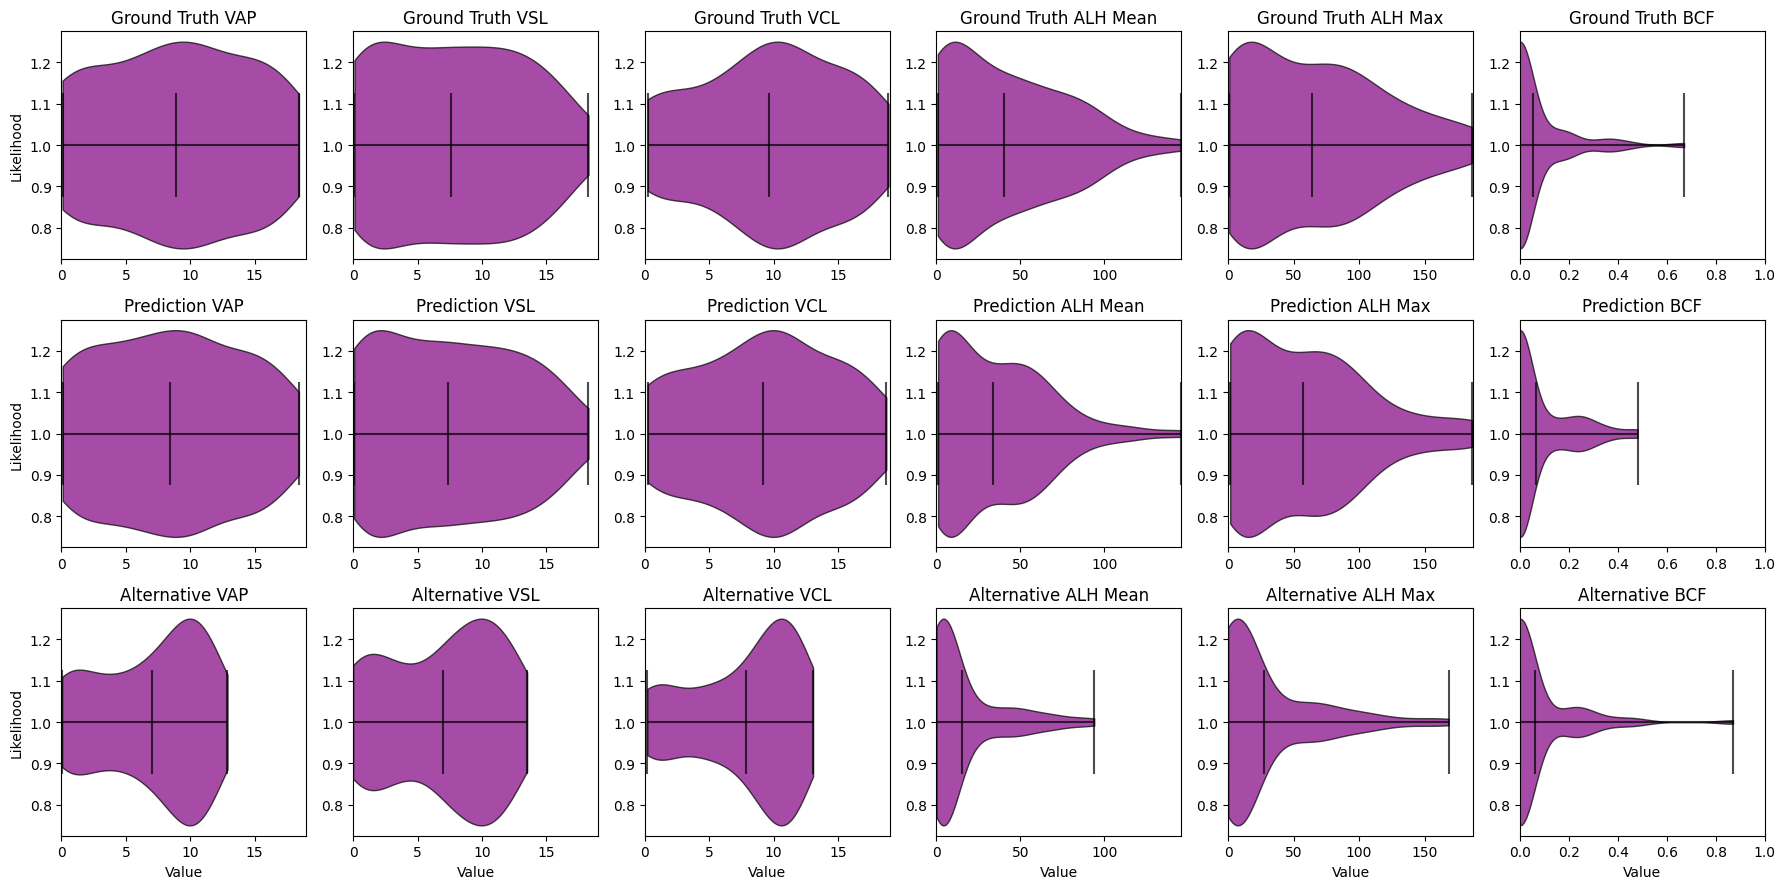

In [83]:
# Build 3x6 subplot for each stat and each method

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

alt_vap = alt.groupby('sperm').first()['VAP']
alt_vsl = alt.groupby('sperm').first()['VSL']
alt_vcl = alt.groupby('sperm').first()['VCL']
alt_alh_mean = alt.groupby('sperm').first()['ALH_mean']
alt_alh_max = alt.groupby('sperm').first()['ALH_max']
alt_bcf = alt.groupby('sperm').first()['BCF']

# Create a figure with 3 rows and 6 columns
fig, axs = plt.subplots(3, 6, figsize=(18, 9))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), alt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), alt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), alt_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), alt_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), alt_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), alt_bcf.max()))

# Create horizontal violin plots for each stat and each method
axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
axs[0, 0].set_title('Ground Truth VAP')
axs[1, 0].violinplot(pred_vap, vert=False, showmeans=True)
axs[1, 0].set_title('Prediction VAP')
axs[2, 0].violinplot(alt_vap, vert=False, showmeans=True)
axs[2, 0].set_title('Alternative VAP')
axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
axs[0, 1].set_title('Ground Truth VSL')
axs[1, 1].violinplot(pred_vsl, vert=False, showmeans=True)
axs[1, 1].set_title('Prediction VSL')
axs[2, 1].violinplot(alt_vsl, vert=False, showmeans=True)
axs[2, 1].set_title('Alternative VSL')
axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
axs[0, 2].set_title('Ground Truth VCL')
axs[1, 2].violinplot(pred_vcl, vert=False, showmeans=True)
axs[1, 2].set_title('Prediction VCL')
axs[2, 2].violinplot(alt_vcl, vert=False, showmeans=True)
axs[2, 2].set_title('Alternative VCL')
axs[0, 3].violinplot(gt_alh_mean, vert=False, showmeans=True)
axs[0, 3].set_title('Ground Truth ALH Mean')
axs[1, 3].violinplot(pred_alh_mean, vert=False, showmeans=True)
axs[1, 3].set_title('Prediction ALH Mean')
axs[2, 3].violinplot(alt_alh_mean, vert=False, showmeans=True)
axs[2, 3].set_title('Alternative ALH Mean')
axs[0, 4].violinplot(gt_alh_max, vert=False, showmeans=True)
axs[0, 4].set_title('Ground Truth ALH Max')
axs[1, 4].violinplot(pred_alh_max, vert=False, showmeans=True)
axs[1, 4].set_title('Prediction ALH Max')
axs[2, 4].violinplot(alt_alh_max, vert=False, showmeans=True)
axs[2, 4].set_title('Alternative ALH Max')
axs[0, 5].violinplot(gt_bcf, vert=False, showmeans=True)
axs[0, 5].set_title('Ground Truth BCF')
axs[1, 5].violinplot(pred_bcf, vert=False, showmeans=True)
axs[1, 5].set_title('Prediction BCF')
axs[2, 5].violinplot(alt_bcf, vert=False, showmeans=True)
axs[2, 5].set_title('Alternative BCF')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[2, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[2, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)
axs[2, 2].set_xlim(0, vcl_max)
axs[0, 3].set_xlim(0, alh_mean_max)
axs[1, 3].set_xlim(0, alh_mean_max)
axs[2, 3].set_xlim(0, alh_mean_max)
axs[0, 4].set_xlim(0, alh_max_max)
axs[1, 4].set_xlim(0, alh_max_max)
axs[2, 4].set_xlim(0, alh_max_max)
axs[0, 5].set_xlim(0, bcf_max)
axs[1, 5].set_xlim(0, bcf_max)
axs[2, 5].set_xlim(0, bcf_max)

# Set colors of the bodies
for ax in axs.flat:
    for pc in ax.collections:
        pc.set_facecolor('purple')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Likelihood')
for ax in axs[2,:]:
    ax.set_xlabel('Value')  

# Adjust layout
plt.tight_layout()



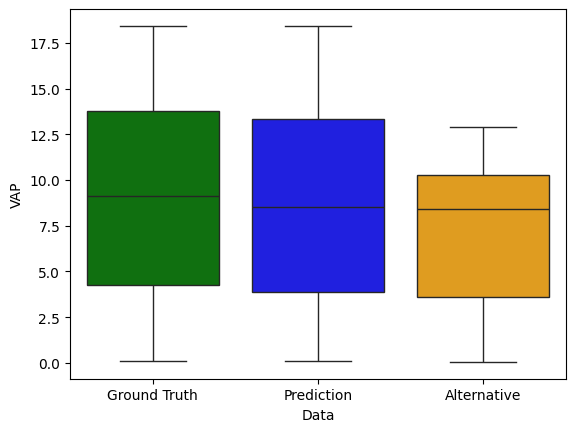

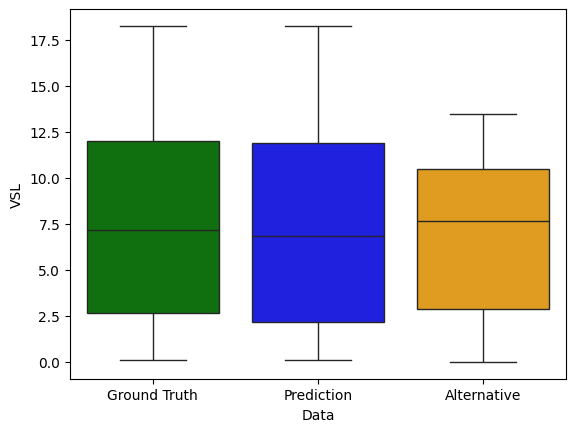

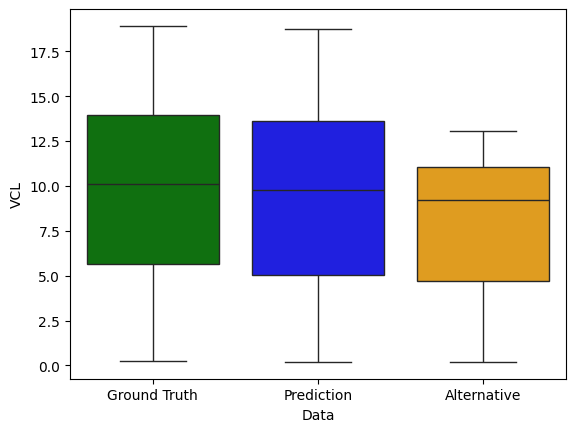

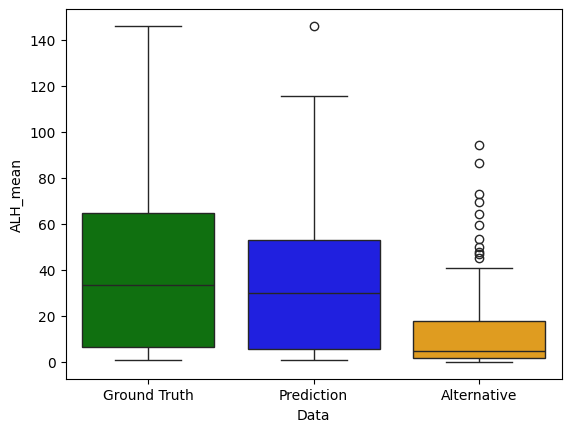

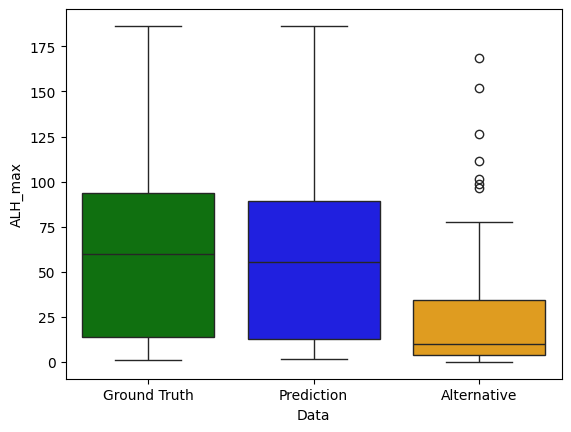

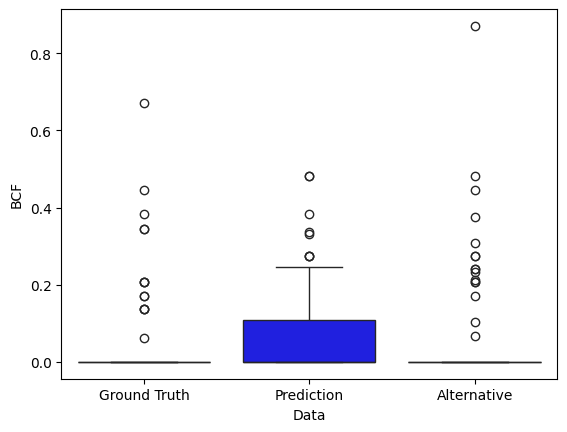

In [84]:
# Same plot, but with side by side box plots

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

alt_vap = alt.groupby('sperm').first()['VAP']
alt_vsl = alt.groupby('sperm').first()['VSL']
alt_vcl = alt.groupby('sperm').first()['VCL']
alt_alh_mean = alt.groupby('sperm').first()['ALH_mean']
alt_alh_max = alt.groupby('sperm').first()['ALH_max']
alt_bcf = alt.groupby('sperm').first()['BCF']

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), alt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), alt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), alt_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), alt_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), alt_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), alt_bcf.max()))

# Create dataframe for box plots side-by-side with seaborn
import pandas as pd

# Concatenate the series for each method
df = pd.DataFrame({
    'Data': (['Ground Truth'] * len(gt_vap)) + (['Prediction'] * len(pred_vap)) + (['Alternative'] * len(alt_vap)),
    'VAP': pd.concat([gt_vap, pred_vap, alt_vap], ignore_index=True),
    'VSL': pd.concat([gt_vsl, pred_vsl, alt_vsl], ignore_index=True),
    'VCL': pd.concat([gt_vcl, pred_vcl, alt_vcl], ignore_index=True),
    'ALH_mean': pd.concat([gt_alh_mean, pred_alh_mean, alt_alh_mean], ignore_index=True),
    'ALH_max': pd.concat([gt_alh_max, pred_alh_max, alt_alh_max], ignore_index=True),
    'BCF': pd.concat([gt_bcf, pred_bcf, alt_bcf], ignore_index=True)
})

import seaborn as sns
colors = {'Ground Truth': 'green', 'Prediction': 'blue', 'Alternative': 'orange'}
sns.boxplot(x="Data", y="VAP", hue="Data", data=df, palette=colors)
plt.show()

sns.boxplot(x="Data", y="VSL", hue="Data", data=df, palette=colors)
plt.show()

sns.boxplot(x="Data", y="VCL", hue="Data", data=df, palette=colors)
plt.show()

sns.boxplot(x="Data", y="ALH_mean", hue="Data", data=df, palette=colors)
plt.show()

sns.boxplot(x="Data", y="ALH_max", hue="Data", data=df, palette=colors)
plt.show()

sns.boxplot(x="Data", y="BCF", hue="Data", data=df, palette=colors)
plt.show()

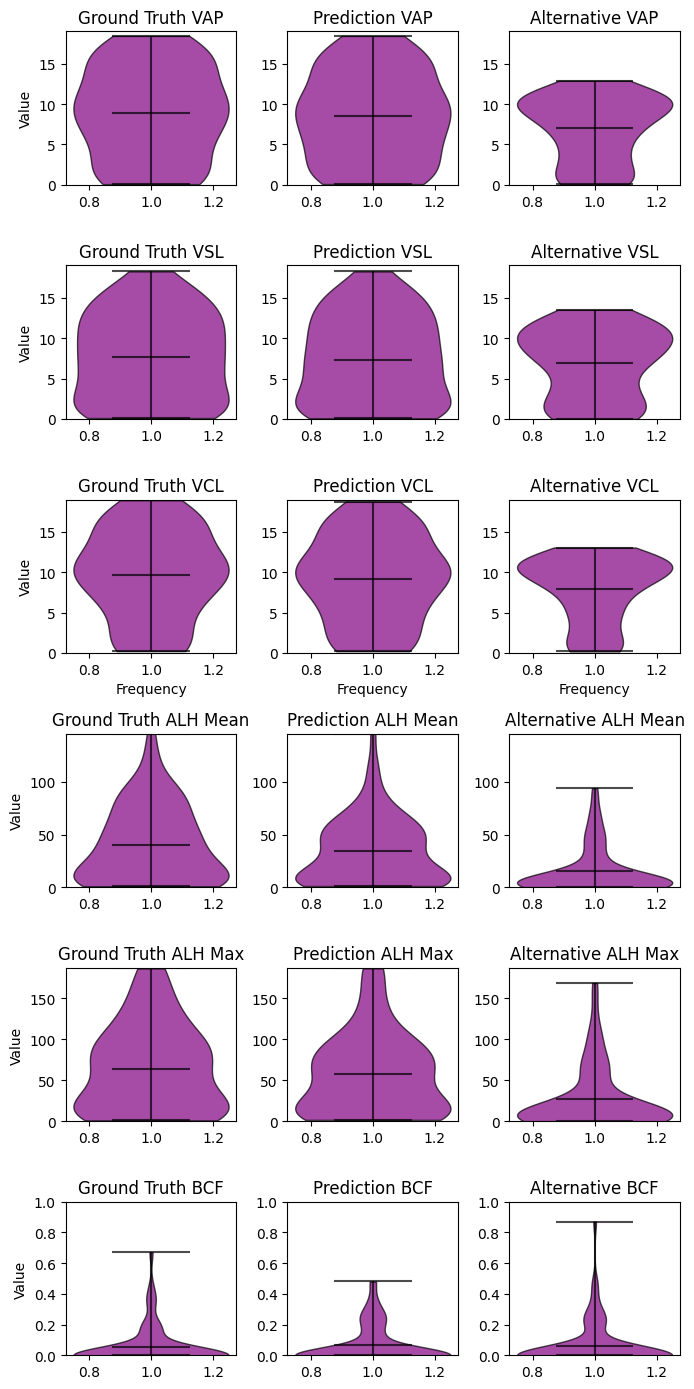

In [85]:
# Transpose of the previous plot
pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

alt_vap = alt.groupby('sperm').first()['VAP']
alt_vsl = alt.groupby('sperm').first()['VSL']
alt_vcl = alt.groupby('sperm').first()['VCL']
alt_alh_mean = alt.groupby('sperm').first()['ALH_mean']
alt_alh_max = alt.groupby('sperm').first()['ALH_max']
alt_bcf = alt.groupby('sperm').first()['BCF']

# Create a figure with 6 rows and 3 columns
fig, axs = plt.subplots(6, 3, figsize=(7, 14))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), alt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), alt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), alt_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), alt_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), alt_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), alt_bcf.max()))

# Create horizontal violin plots for each stat and each method
axs[0, 0].violinplot(gt_vap, showmeans=True)
axs[0, 0].set_title('Ground Truth VAP')
axs[0, 1].violinplot(pred_vap, showmeans=True)
axs[0, 1].set_title('Prediction VAP')
axs[0, 2].violinplot(alt_vap, showmeans=True)
axs[0, 2].set_title('Alternative VAP')
axs[1, 0].violinplot(gt_vsl, showmeans=True)
axs[1, 0].set_title('Ground Truth VSL')
axs[1, 1].violinplot(pred_vsl, showmeans=True)
axs[1, 1].set_title('Prediction VSL')
axs[1, 2].violinplot(alt_vsl, showmeans=True)
axs[1, 2].set_title('Alternative VSL')
axs[2, 0].violinplot(gt_vcl, showmeans=True)
axs[2, 0].set_title('Ground Truth VCL')
axs[2, 1].violinplot(pred_vcl, showmeans=True)
axs[2, 1].set_title('Prediction VCL')
axs[2, 2].violinplot(alt_vcl, showmeans=True)
axs[2, 2].set_title('Alternative VCL')
axs[3, 0].violinplot(gt_alh_mean, showmeans=True)
axs[3, 0].set_title('Ground Truth ALH Mean')
axs[3, 1].violinplot(pred_alh_mean, showmeans=True)
axs[3, 1].set_title('Prediction ALH Mean')
axs[3, 2].violinplot(alt_alh_mean, showmeans=True)
axs[3, 2].set_title('Alternative ALH Mean')
axs[4, 0].violinplot(gt_alh_max, showmeans=True)
axs[4, 0].set_title('Ground Truth ALH Max')
axs[4, 1].violinplot(pred_alh_max, showmeans=True)
axs[4, 1].set_title('Prediction ALH Max')
axs[4, 2].violinplot(alt_alh_max, showmeans=True)
axs[4, 2].set_title('Alternative ALH Max')
axs[5, 0].violinplot(gt_bcf, showmeans=True)
axs[5, 0].set_title('Ground Truth BCF')
axs[5, 1].violinplot(pred_bcf, showmeans=True)
axs[5, 1].set_title('Prediction BCF')
axs[5, 2].violinplot(alt_bcf, showmeans=True)
axs[5, 2].set_title('Alternative BCF')

# Set y-limits for each subplot
axs[0, 0].set_ylim(0, vap_max)
axs[0, 1].set_ylim(0, vap_max)
axs[0, 2].set_ylim(0, vap_max)
axs[1, 0].set_ylim(0, vsl_max)
axs[1, 1].set_ylim(0, vsl_max)
axs[1, 2].set_ylim(0, vsl_max)
axs[2, 0].set_ylim(0, vcl_max)
axs[2, 1].set_ylim(0, vcl_max)
axs[2, 2].set_ylim(0, vcl_max)
axs[3, 0].set_ylim(0, alh_mean_max)
axs[3, 1].set_ylim(0, alh_mean_max)
axs[3, 2].set_ylim(0, alh_mean_max)
axs[4, 0].set_ylim(0, alh_max_max)
axs[4, 1].set_ylim(0, alh_max_max)
axs[4, 2].set_ylim(0, alh_max_max)
axs[5, 0].set_ylim(0, bcf_max)
axs[5, 1].set_ylim(0, bcf_max)
axs[5, 2].set_ylim(0, bcf_max)

# Set colors of the bodies
for ax in axs.flat:
    for pc in ax.collections:
        pc.set_facecolor('purple')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Value')
for ax in axs[2,:]:
    ax.set_xlabel('Frequency')  

# Adjust layout
plt.tight_layout()


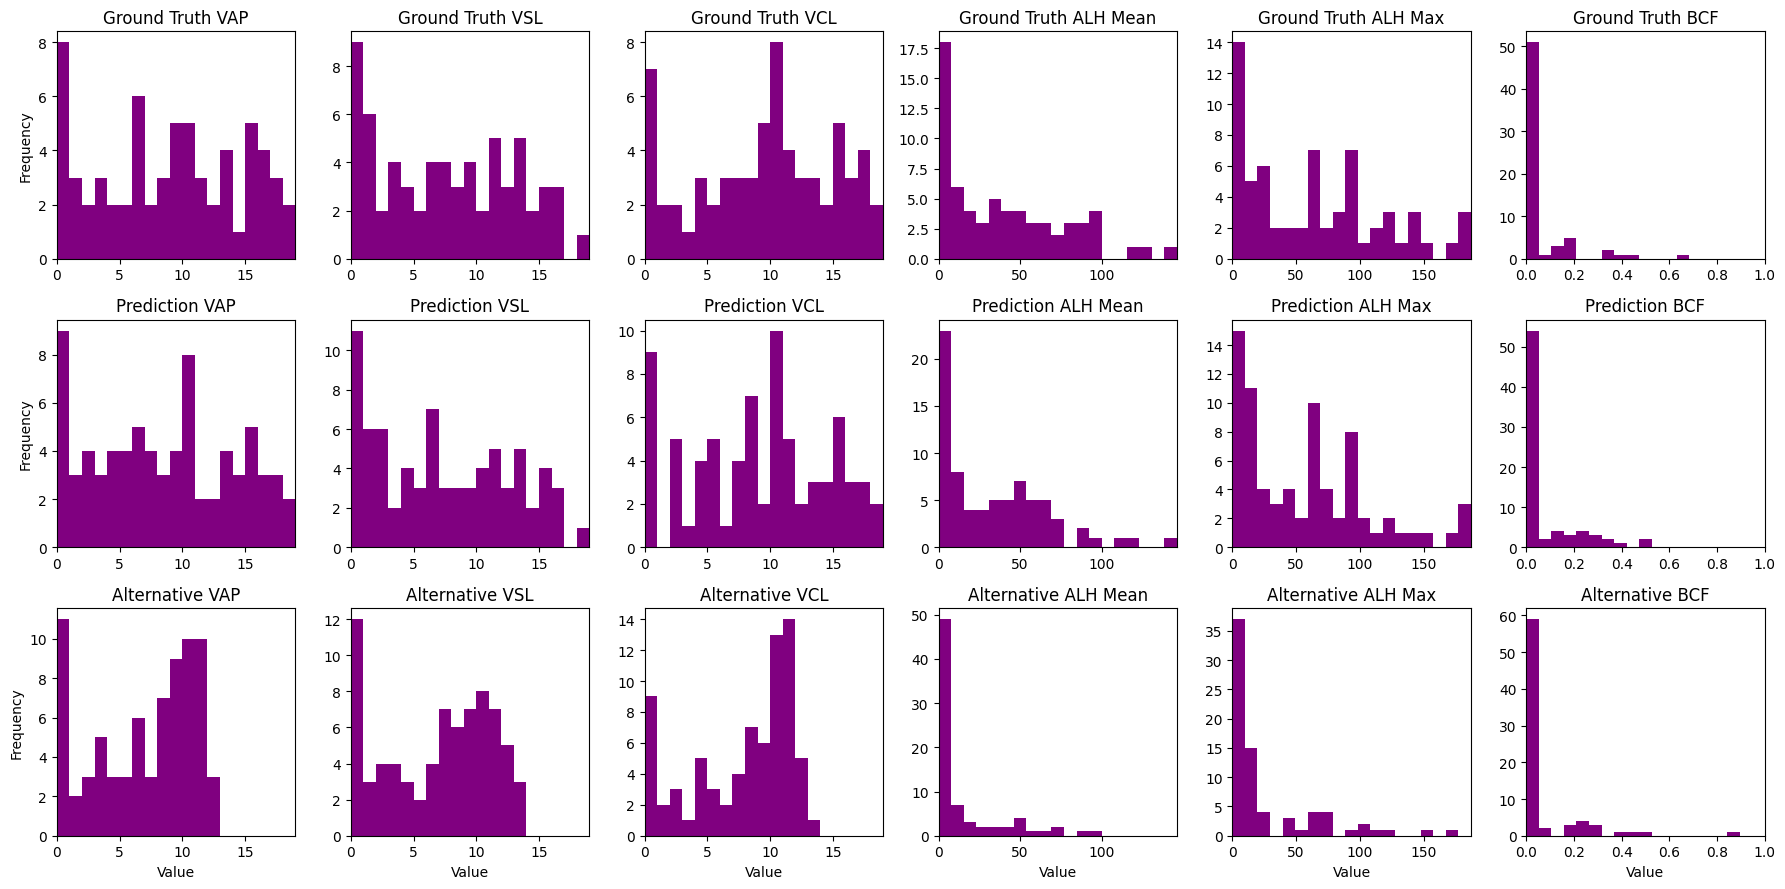

In [86]:
# Build 3x6 subplot for each stat and each method of histograms

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

alt_vap = alt.groupby('sperm').first()['VAP']
alt_vsl = alt.groupby('sperm').first()['VSL']
alt_vcl = alt.groupby('sperm').first()['VCL']
alt_alh_mean = alt.groupby('sperm').first()['ALH_mean']
alt_alh_max = alt.groupby('sperm').first()['ALH_max']
alt_bcf = alt.groupby('sperm').first()['BCF']

# Create a figure with 3 rows and 6 columns
fig, axs = plt.subplots(3, 6, figsize=(18, 9))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), alt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), alt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), alt_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), alt_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), alt_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), alt_bcf.max()))

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)
alh_mean_bins = np.linspace(0, alh_mean_max, 20)
alh_max_bins = np.linspace(0, alh_max_max, 20)
bcf_bins = np.linspace(0, bcf_max, 20)

# Create horizontal violin plots for each stat and each method
axs[0, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[0, 0].set_title('Ground Truth VAP')
axs[1, 0].hist(pred_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[1, 0].set_title('Prediction VAP')
axs[2, 0].hist(alt_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[2, 0].set_title('Alternative VAP')
axs[0, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[0, 1].set_title('Ground Truth VSL')
axs[1, 1].hist(pred_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[1, 1].set_title('Prediction VSL')
axs[2, 1].hist(alt_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[2, 1].set_title('Alternative VSL')
axs[0, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[0, 2].set_title('Ground Truth VCL')
axs[1, 2].hist(pred_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[1, 2].set_title('Prediction VCL')
axs[2, 2].hist(alt_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[2, 2].set_title('Alternative VCL')
axs[0, 3].hist(gt_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[0, 3].set_title('Ground Truth ALH Mean')
axs[1, 3].hist(pred_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[1, 3].set_title('Prediction ALH Mean')
axs[2, 3].hist(alt_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[2, 3].set_title('Alternative ALH Mean')
axs[0, 4].hist(gt_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[0, 4].set_title('Ground Truth ALH Max')
axs[1, 4].hist(pred_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[1, 4].set_title('Prediction ALH Max')
axs[2, 4].hist(alt_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[2, 4].set_title('Alternative ALH Max')
axs[0, 5].hist(gt_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[0, 5].set_title('Ground Truth BCF')
axs[1, 5].hist(pred_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[1, 5].set_title('Prediction BCF')
axs[2, 5].hist(alt_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[2, 5].set_title('Alternative BCF')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[2, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[2, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)
axs[2, 2].set_xlim(0, vcl_max)
axs[0, 3].set_xlim(0, alh_mean_max)
axs[1, 3].set_xlim(0, alh_mean_max)
axs[2, 3].set_xlim(0, alh_mean_max)
axs[0, 4].set_xlim(0, alh_max_max)
axs[1, 4].set_xlim(0, alh_max_max)
axs[2, 4].set_xlim(0, alh_max_max)
axs[0, 5].set_xlim(0, bcf_max)
axs[1, 5].set_xlim(0, bcf_max)
axs[2, 5].set_xlim(0, bcf_max)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Frequency')
for ax in axs[2,:]:
    ax.set_xlabel('Value')  

# Adjust layout
plt.tight_layout()

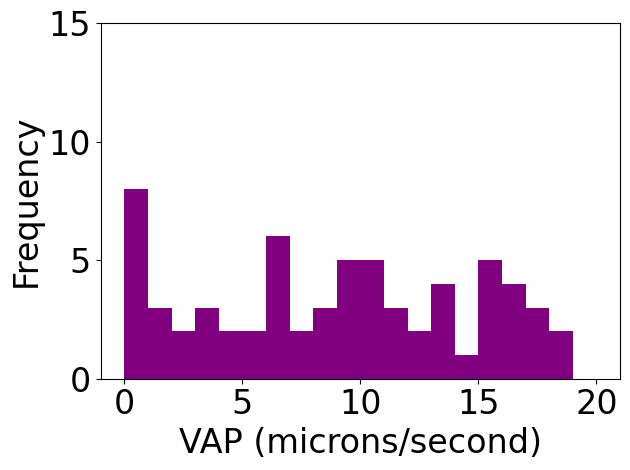

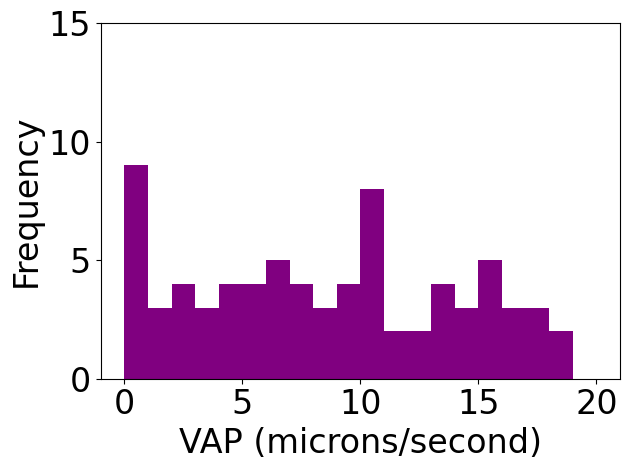

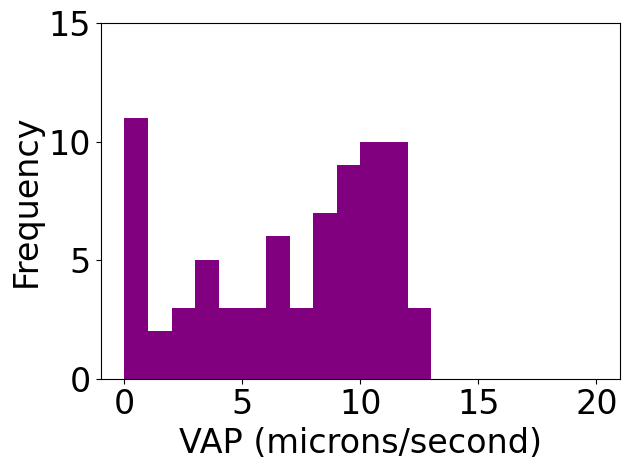

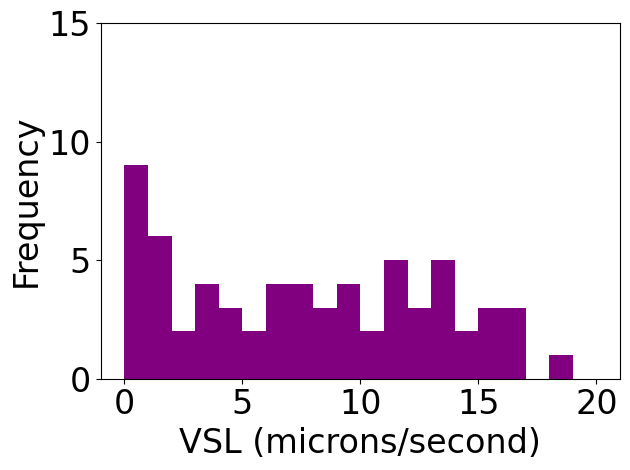

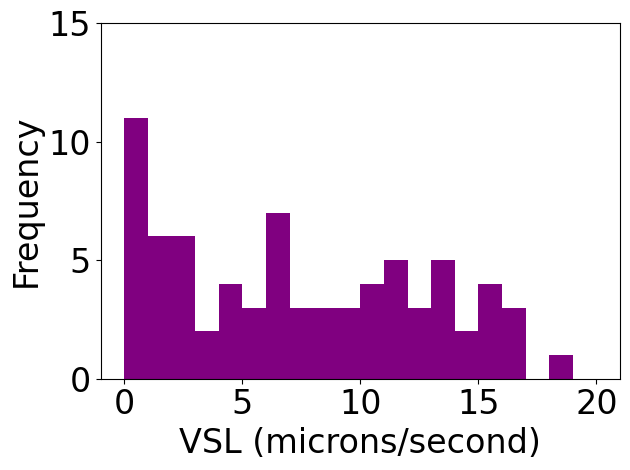

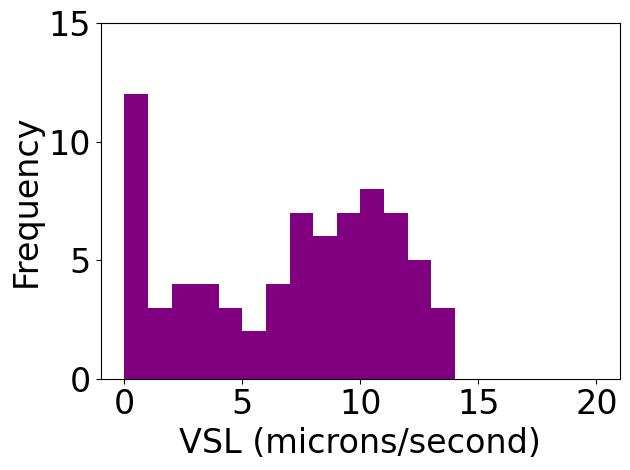

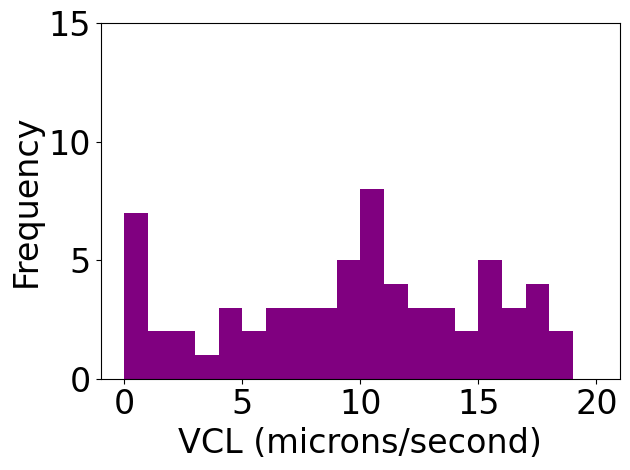

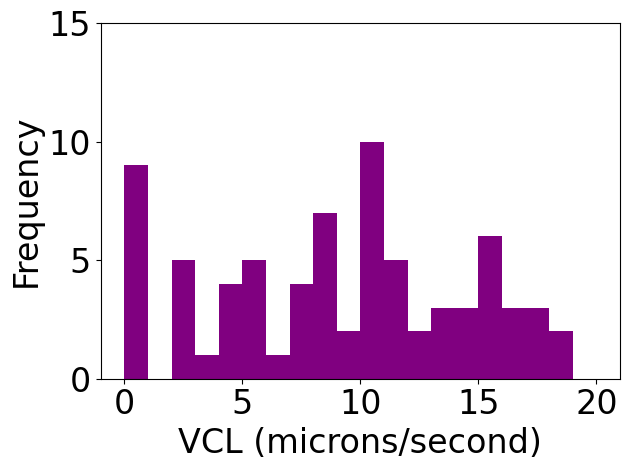

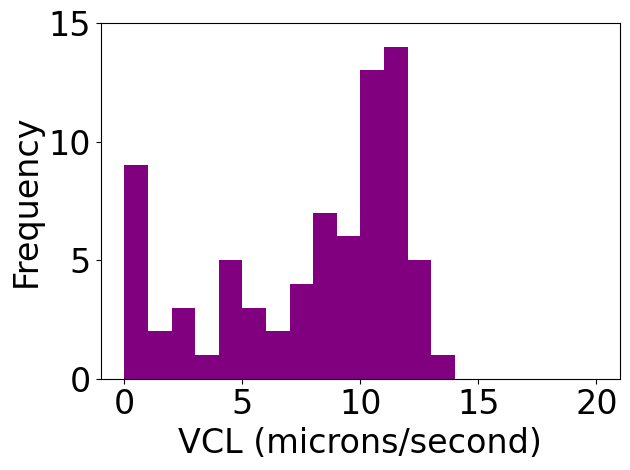

In [87]:
import matplotlib.pyplot as plt

# Generate historgrams for VSL, VCL, and VAP
def plotStat(data,stat="VAP",method="gt",fs = 24):

    # Get unique sperm
    sperm_ids = data['sperm'].unique()

    # Get first stat values for each sperm id
    first_values = data.groupby('sperm').first()[stat]

    plt.hist(first_values, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], alpha=1.0, color='purple')
    plt.xlabel(stat + " (microns/second)",fontsize=fs)
    xticks = [0,5,10,15,20]
    plt.xticks(xticks, xticks, fontsize=fs)
    plt.ylabel('Frequency', fontsize=fs)
    yticks = [0,5,10,15]
    plt.yticks(yticks, yticks, fontsize=fs)
    #plt.title(f'{stat} Distribution')
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'{stat}_distribution_{method}.pdf')
    plt.show()

plotStat(gt,stat="VAP")
plotStat(pred,stat="VAP")
plotStat(alt,stat="VAP")

plotStat(gt,stat="VSL")
plotStat(pred,stat="VSL")
plotStat(alt,stat="VSL")

plotStat(gt,stat="VCL")
plotStat(pred,stat="VCL")
plotStat(alt,stat="VCL")



## Experiment 2

In [103]:
prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

#prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)

In [104]:
# Make versions of the DataFrames with only the 2 seconds (18 frames) of each sperm
pred_2s = pred[pred['frame'] < 18]
gt_2s = gt[gt['frame'] < 18]

In [105]:
# Compute stats for each file
ps = 0.26  # pixel size in micrometers
gt = stats.computeAllStats(gt,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred,pixel_size=ps,interpolate=False)

pred_2s = stats.computeAllStats(pred_2s,pixel_size=ps,interpolate=False)
gt_2s = stats.computeAllStats(gt_2s,pixel_size=ps,interpolate=False)

/Users/hartda23/Documents/Sperm_Object_Tracking/UnifiedFramework/stats.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sperm'] == sperm_id, 'VAP'] = vap
/Users/hartda23/Documents/Sperm_Object_Tracking/UnifiedFramework/stats.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sperm'] == sperm_id, 'VCL'] = average_speed
/Users/hartda23/Documents/Sperm_Object_Tracking/UnifiedFramework/stats.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [106]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction", "Prediction_2s"], "VAP": [None, None], "VSL": [None, None], "VCL": [None, None], "ALH_mean": [None, None], "ALH_max": [None, None], "BCF": [None, None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])
    emd_df.loc[1, stat] = wasserstein_distance(gt[stat], pred_2s[stat])

# Print the EMD DataFrame
print(emd_df)

          Method       VAP       VSL       VCL ALH_mean ALH_max       BCF
0     Prediction  1.574566  1.301601  1.764652      NaN     NaN  0.076159
1  Prediction_2s  2.695675  1.197011  2.746581      NaN     NaN       NaN


In [107]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Prediction_2s': [pred_2s['VAP'].max(), pred_2s['VSL'].max(), pred_2s['VCL'].max(), pred_2s['ALH_mean'].max(), pred_2s['ALH_max'].max(), pred_2s['BCF'].max()]
})

print(summary_df)

print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Ground Truth  Prediction  Prediction_2s
0       VAP     21.052012   21.049852      18.818052
1       VSL     21.048720   21.046848      20.030464
2       VCL     22.150472   22.132560      19.114351
3  ALH_mean    158.766993  176.272681       4.302492
4   ALH_max    316.037337  257.512534       4.904178
5       BCF      0.312741    0.866667       2.076923
Mins: 0.10175568143727616 0.050626741830122245 0.21803975542640178 1.0928067853971242 1.8940316253998601 0.0


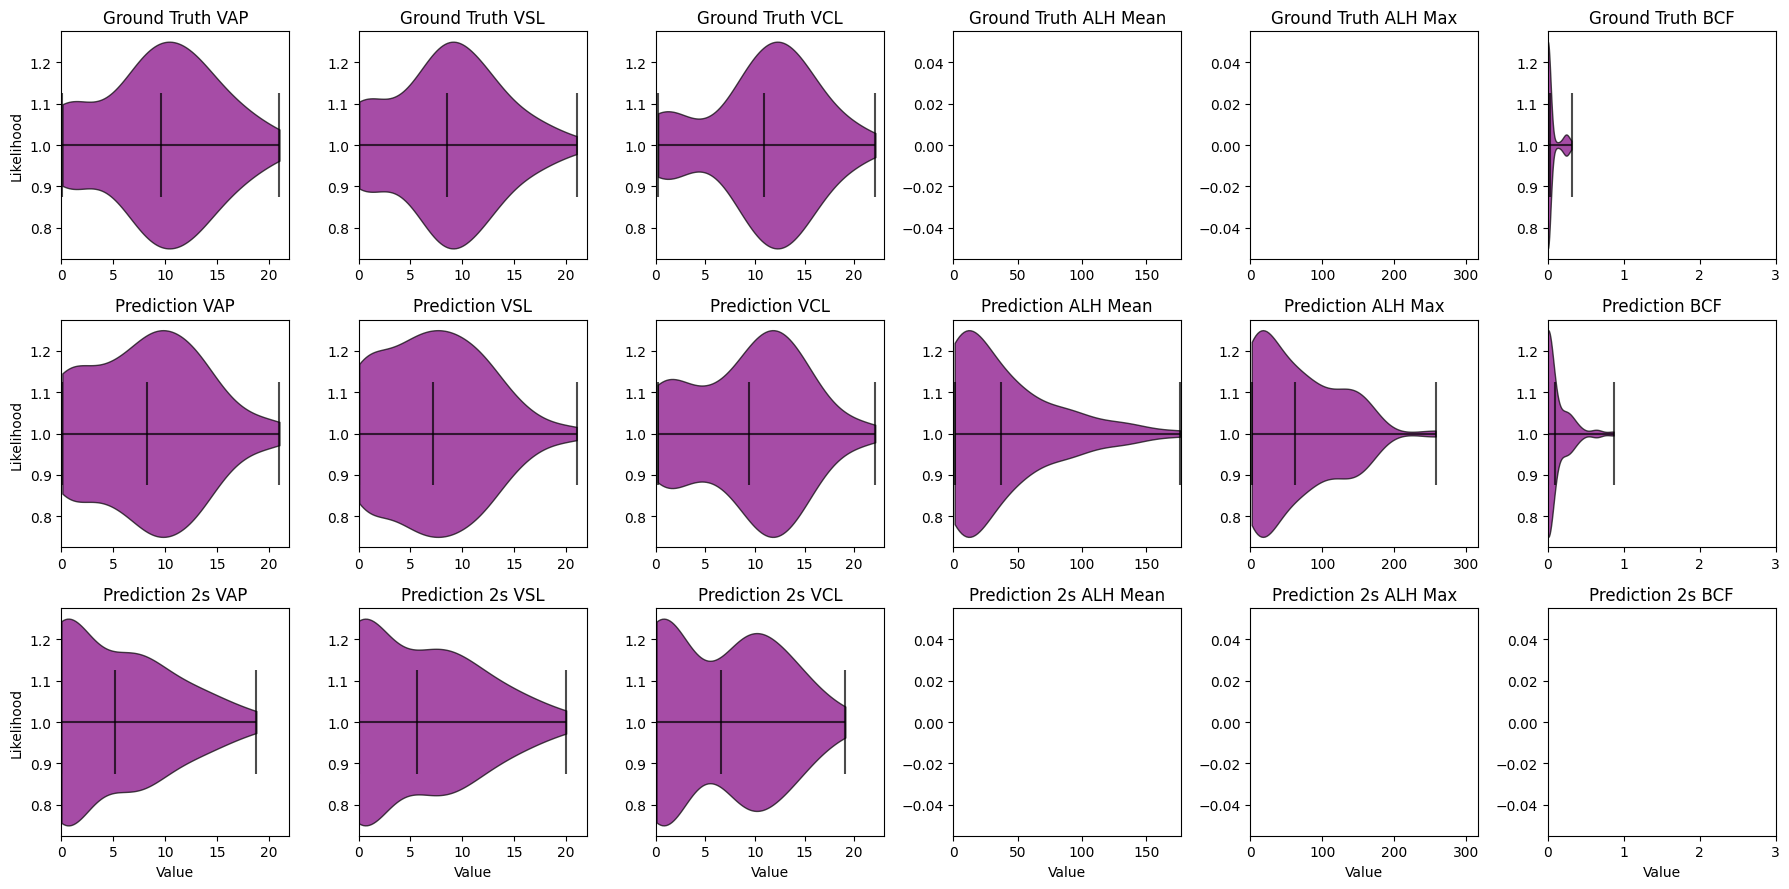

In [108]:
# Build 3x6 subplot for each stat and each method

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

pred_2s_vap = pred_2s.groupby('sperm').first()['VAP']
pred_2s_vsl = pred_2s.groupby('sperm').first()['VSL']
pred_2s_vcl = pred_2s.groupby('sperm').first()['VCL']
pred_2s_alh_mean = pred_2s.groupby('sperm').first()['ALH_mean']
pred_2s_alh_max = pred_2s.groupby('sperm').first()['ALH_max']
pred_2s_bcf = pred_2s.groupby('sperm').first()['BCF']

# Create a figure with 3 rows and 6 columns
fig, axs = plt.subplots(3, 6, figsize=(18, 9))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), pred_2s_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), pred_2s_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), pred_2s_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), pred_2s_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), pred_2s_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), pred_2s_bcf.max()))

# Create horizontal violin plots for each stat and each method
axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
axs[0, 0].set_title('Ground Truth VAP')
axs[1, 0].violinplot(pred_vap, vert=False, showmeans=True)
axs[1, 0].set_title('Prediction VAP')
axs[2, 0].violinplot(pred_2s_vap, vert=False, showmeans=True)
axs[2, 0].set_title('Prediction 2s VAP')
axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
axs[0, 1].set_title('Ground Truth VSL')
axs[1, 1].violinplot(pred_vsl, vert=False, showmeans=True)
axs[1, 1].set_title('Prediction VSL')
axs[2, 1].violinplot(pred_2s_vsl, vert=False, showmeans=True)
axs[2, 1].set_title('Prediction 2s VSL')
axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
axs[0, 2].set_title('Ground Truth VCL')
axs[1, 2].violinplot(pred_vcl, vert=False, showmeans=True)
axs[1, 2].set_title('Prediction VCL')
axs[2, 2].violinplot(pred_2s_vcl, vert=False, showmeans=True)
axs[2, 2].set_title('Prediction 2s VCL')
axs[0, 3].violinplot(gt_alh_mean, vert=False, showmeans=True)
axs[0, 3].set_title('Ground Truth ALH Mean')
axs[1, 3].violinplot(pred_alh_mean, vert=False, showmeans=True)
axs[1, 3].set_title('Prediction ALH Mean')
axs[2, 3].violinplot(pred_2s_alh_mean, vert=False, showmeans=True)
axs[2, 3].set_title('Prediction 2s ALH Mean')
axs[0, 4].violinplot(gt_alh_max, vert=False, showmeans=True)
axs[0, 4].set_title('Ground Truth ALH Max')
axs[1, 4].violinplot(pred_alh_max, vert=False, showmeans=True)
axs[1, 4].set_title('Prediction ALH Max')
axs[2, 4].violinplot(pred_2s_alh_max, vert=False, showmeans=True)
axs[2, 4].set_title('Prediction 2s ALH Max')
axs[0, 5].violinplot(gt_bcf, vert=False, showmeans=True)
axs[0, 5].set_title('Ground Truth BCF')
axs[1, 5].violinplot(pred_bcf, vert=False, showmeans=True)
axs[1, 5].set_title('Prediction BCF')
axs[2, 5].violinplot(pred_2s_bcf, vert=False, showmeans=True)
axs[2, 5].set_title('Prediction 2s BCF')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[2, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[2, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)
axs[2, 2].set_xlim(0, vcl_max)
axs[0, 3].set_xlim(0, alh_mean_max)
axs[1, 3].set_xlim(0, alh_mean_max)
axs[2, 3].set_xlim(0, alh_mean_max)
axs[0, 4].set_xlim(0, alh_max_max)
axs[1, 4].set_xlim(0, alh_max_max)
axs[2, 4].set_xlim(0, alh_max_max)
axs[0, 5].set_xlim(0, bcf_max)
axs[1, 5].set_xlim(0, bcf_max)
axs[2, 5].set_xlim(0, bcf_max)

# Set colors of the bodies
for ax in axs.flat:
    for pc in ax.collections:
        pc.set_facecolor('purple')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Likelihood')
for ax in axs[2,:]:
    ax.set_xlabel('Value')  

# Adjust layout
plt.tight_layout()

